In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [3]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100

In [4]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(N_inp, N_bar, num_states, steps=steps)

In [5]:
cache_states = [0, 10, 20, 30, 40, 50, 60, 70, 80]

# Run Task (with learning)

In [6]:
model.reset()
cache_acts = []
cache_acts_over_time = []

for cache_state in cache_states:
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])
    cache_acts.append(acts.copy())
    cache_acts_over_time.append(acts_over_time.copy())

Now I just cached at location: 0
Now I just cached at location: 10
Now I just cached at location: 20
Now I just cached at location: 30
Now I just cached at location: 40
Now I just cached at location: 50
Now I just cached at location: 60
Now I just cached at location: 70
Now I just cached at location: 80


In [7]:
_, _, output, retrieval_acts_over_time = model.run_recall(0., place_inputs)

In [8]:
_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)
place_mean = np.mean(place_acts, axis=0).flatten()
place_std = np.std(place_acts, axis=0).flatten()

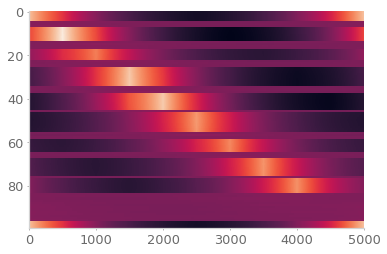

In [9]:
plt.figure()
plt.imshow(output, aspect='auto')
plt.show()

# Define cache activity as a mean over some time window

In [10]:
avg_cache_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = cache_acts_over_time[i][steps+model.seed_steps-1, location, :]#.mean(axis=0)
    avg_cache_acts.append(vec)
avg_cache_acts = np.array(avg_cache_acts)

In [11]:
cache_mean = avg_cache_acts.mean(axis=0)

In [12]:
avg_retrieval_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = retrieval_acts_over_time[steps-1, location, :]#.mean(axis=0)
    avg_retrieval_acts.append(vec)
avg_retrieval_acts = np.array(avg_retrieval_acts)

In [13]:
def nb(mu, std_scaling=1.0, mu_scaling=0.75, shift=0.0):
    """ mu is a vector of firing rates. std_scaling is a scalar. """


    mu = mu*mu_scaling + 1E-8 + shift
    std = std_scaling * np.sqrt(mu)
    std += 1E-8
    n = (mu**2)/(std**2 - mu)
    p = mu/(std**2)
    nb_mu = nbinom.rvs(n, p)
    return nb_mu.astype(float)


def nb_corr(a, b):
    nb_a = nb(a)
    nb_b = nb(b)
    return np.corrcoef(nb_a, nb_b)[0, 1]

# Fig 3ab, Fig 4: cache v. visit correlation

In [14]:
cache_cache_corr = {'Distance': [], 'Correlation': []}
cache_visit_corr = {'Distance': [], 'Correlation': []}
visit_visit_corr = {'Distance': [], 'Correlation': []}
cache_retrieval_corr = {'Distance': [], 'Correlation': []}
std_scaling = 1

for i in range(len(cache_states)):
    for j in range(i, len(cache_states)):
        _distance = distance(cache_states[i], cache_states[j], num_states)
        
        cache_act_i = avg_cache_acts[i].copy()
        cache_act_j = avg_cache_acts[j].copy()
        retrieval_act_j = avg_retrieval_acts[j].copy()
        place_act_i = place_acts[cache_states[i]].copy()
        place_act_j = place_acts[cache_states[j]].copy()
        
        for _ in range(3): # More samples
            c_c_corr = nb_corr(cache_act_i, cache_act_j)
            c_v_corr = nb_corr(cache_act_i, place_act_j)
            v_v_corr = nb_corr(place_act_i, place_act_j)
            c_r_corr = nb_corr(cache_act_i, retrieval_act_j)

            cache_cache_corr['Distance'].append(_distance)
            cache_cache_corr['Correlation'].append(c_c_corr)

            cache_visit_corr['Distance'].append(_distance)
            cache_visit_corr['Correlation'].append(c_v_corr)

            visit_visit_corr['Distance'].append(_distance)
            visit_visit_corr['Correlation'].append(v_v_corr)
            
            cache_retrieval_corr['Distance'].append(_distance)
            cache_retrieval_corr['Correlation'].append(c_r_corr)


In [15]:
# cc

In [16]:
ccc = pd.DataFrame(cache_cache_corr)
ccc = ccc[ccc['Distance']==0]
print(ccc)

     Distance  Correlation
0           0     0.486882
1           0     0.506644
2           0     0.521794
27          0     0.482542
28          0     0.513541
29          0     0.565079
51          0     0.511978
52          0     0.489791
53          0     0.511659
72          0     0.532850
73          0     0.563818
74          0     0.473312
90          0     0.553804
91          0     0.559274
92          0     0.495418
105         0     0.468446
106         0     0.516875
107         0     0.486220
117         0     0.515141
118         0     0.482844
119         0     0.492608
126         0     0.531145
127         0     0.499987
128         0     0.521528
132         0     0.496736
133         0     0.582225
134         0     0.494320


In [17]:
np.mean(ccc)

Distance       0.000000
Correlation    0.513202
dtype: float64

In [18]:
# cr

In [19]:
crc = pd.DataFrame(cache_retrieval_corr)
crc = crc[crc['Distance']==0]
print(crc)

     Distance  Correlation
0           0     0.524193
1           0     0.519757
2           0     0.497353
27          0     0.596469
28          0     0.538778
29          0     0.539563
51          0     0.416624
52          0     0.477869
53          0     0.462738
72          0     0.530704
73          0     0.538481
74          0     0.557293
90          0     0.541462
91          0     0.519190
92          0     0.570355
105         0     0.455543
106         0     0.519451
107         0     0.491905
117         0     0.455578
118         0     0.532065
119         0     0.543042
126         0     0.545949
127         0     0.513619
128         0     0.436076
132         0     0.476832
133         0     0.503051
134         0     0.500483


In [20]:
np.mean(crc)

Distance       0.000000
Correlation    0.511275
dtype: float64

In [21]:
# vv

In [22]:
vvc = pd.DataFrame(visit_visit_corr)
vvc = vvc[vvc['Distance']==0]

In [23]:
np.mean(vvc)

Distance       0.000000
Correlation    0.219682
dtype: float64

# Plot

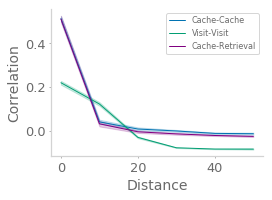

In [24]:
plt.figure(figsize=(4,3))
sns.lineplot(
    x='Distance', y='Correlation', data=pd.DataFrame(cache_cache_corr),
    color='C0', label='Cache-Cache')
sns.lineplot(x='Distance', y='Correlation', data=pd.DataFrame(visit_visit_corr),
    color='C2', label='Visit-Visit')
sns.lineplot(x='Distance', y='Correlation', data=pd.DataFrame(cache_retrieval_corr),
    color='purple', label='Cache-Retrieval')
plt.tight_layout()
plt.savefig('c_r_corr.png')
plt.show()